# Libs & Util

In [1]:
# Extracting Features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import noisereduce as nr
import IPython
from tqdm.notebook import tqdm
import json

# Training neural networks
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Live detection
import pyaudio
from IPython.display import clear_output
import wave

# ms per chunk
STEP = 50
PATH = "whistle_dataset/"

Using TensorFlow backend.
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dverm\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Extracting features

## Chunk processor

>The chunk processor will get a sample with a feature type, and will utilize these to process said chunk into features. The chunk processor is used in both featurizers, but with different window values.

In [2]:
def chunk_processor(sample, sample_rate, feature_type, target, true_window, false_window):
    
    # get correct window variable
    if target:
        window = true_window
    else:
        window = false_window
        
    # calculate chunk size
    chunk = int((sample_rate / 1000) * STEP)
    
    # iterate over sample and fetch features
    for i in tqdm(range(0, len(sample) - chunk, int(chunk * window)), leave=False):
        if feature_type == "fft":
            chunk_features = np.mean(np.abs(librosa.stft(sample[i:i+chunk], n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            chunk_features = np.mean(librosa.feature.mfcc(y=sample[i:i+chunk], sr=sample_rate, n_mfcc=40).T, axis=0)
        
        try:
            features = np.append(features, np.array([chunk_features]), axis=0)
        except:
            features = np.array([chunk_features])
            
    return features, np.full(len(features), int(target))

## Featurizer V1

> Featurizer 1 only uses the whistle, and the segments before and after (same length). This is how a 2:1 label ratio is managed. Sequential samples also have 80% overlap.

In [3]:
# old windows were 1/5
def build_feature_dataframe_v1(feature_type, denoise=False, true_window=1/5):
    """Convert all whistles and small fragments before and after said whistles into features"""
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)

        # for all positive intervals get part before and after aswell and featurize
        for times in tqdm(labels[file_name], leave=False):
            delta_time = times["end"] - times["start"]
            
            label = False
            for i in range(times["start"]-delta_time, times["end"]+delta_time, delta_time):
                if i >= 0 and i + delta_time <= len(sample):
                    features, targets = chunk_processor(sample[i:i+delta_time], sample_rate, feature_type, label, 
                                                        true_window, true_window)
                    label = not(label)
                    try:
                        out = np.append(out, features, axis=0)
                        target = np.append(target, targets)
                    except:
                        out = features
                        target = targets
                else:
                    print(file_name, i, 'no fit ;(')

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v1_" + feature_type + "_" + str(denoise) + ".csv")
    return df

## Featurizer V2

> Featurizer 2 utilises two different overlap values. True labels have 1/5 overlap, meaning that sequential samples have 80% overlap. False labels have a overlap value of 10, meaning that after each sample taken 9 are skipped. This insures that a 2:1 label ratio is kept while still taking a more fair representation of the dataset. True windows of 1/2 and 1/50 can also be used with succes.

In [4]:
def build_feature_dataframe_v2(feature_type, denoise=False, true_window=1/5):
    false_window = int(STEP * true_window)
    
    # See if csv has been calculated before (saving time)
    try:
        df = pd.read_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv", index_col=0)
        print("Dataframe succesfully loaded from csv!")
        return df
    except:
        pass
    
    # get the labels
    target = []
    with open(PATH + "whistledb.json") as json_file:
        labels = json.load(json_file)["audioFiles"]
        labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
    
    # iterate over all audiofiles
    for file_name in tqdm(os.listdir(PATH)):
        # skip json file
        if file_name.split(".")[-1] != "wav":
            continue

        # load file & meta data
        sample, sample_rate = librosa.load(PATH + file_name, sr=None)
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=sample[0:5000], sr=sample_rate)
        
        # create time intervals
        times_list = [0]
        for times in labels[file_name]:
            times_list += [times["start"], times["end"]]
        if times_list[-1] < len(sample):
            times_list.append(len(sample))
        
        label = False
        for i in tqdm(range(len(times_list)-1), leave=False):
            features, targets = chunk_processor(sample[times_list[i]:times_list[i+1]], sample_rate, feature_type, label, 
                                                true_window, false_window)
            label = not(label)
            try:
                out = np.append(out, features, axis=0)
                target = np.append(target, targets)
            except:
                out = features
                target = targets

    # save them in dataframe
    df = pd.DataFrame(out)
    df=(df-df.min())/(df.max()-df.min())
    df.insert(0, "target", target)
    df.to_csv("data_v2_" + feature_type + "_" + str(denoise) + ".csv")
    return df

In [5]:
def build_features(version, feature_type, denoise):
    if version == 1:
        return build_feature_dataframe_v1(feature_type, denoise)
    elif version == 2:
        return build_feature_dataframe_v2(feature_type, denoise)
    else:
        print("invalid version")

In [6]:
mass_data = build_features(1, "mfcc", False)
print("True label ratio:", round((len(mass_data[mass_data["target"] == 1]) / len(mass_data["target"])) * 100, 1),"%")

Dataframe succesfully loaded from csv!
True label ratio: 33.5 %


## Dataset debugging

> The following code allows for any whistle sample to be extracted in order to check if they are labeled correctly.

In [7]:
# Choose recording
i = -1
fname = os.listdir(PATH)[i]
print(fname)

with open(PATH + "whistledb.json") as json_file:
    labels = json.load(json_file)["audioFiles"]
    labels = {entry["path"] : entry["channels"][1]["whistleLabels"] for entry in labels}
print(labels[fname], len(labels[fname]))

sample_tts, sr = librosa.load(PATH + fname, sr=None)

WhistleTest_tuhhnao16.wav
[{'start': 14930000, 'end': 14970000}, {'start': 19186000, 'end': 19250000}, {'start': 19840000, 'end': 19930000}, {'start': 20339000, 'end': 20400000}, {'start': 20918000, 'end': 20955000}, {'start': 21082000, 'end': 21140000}, {'start': 21463000, 'end': 21520000}, {'start': 23044000, 'end': 23110000}, {'start': 23676000, 'end': 23730000}, {'start': 24353000, 'end': 24410000}, {'start': 27023000, 'end': 27060000}, {'start': 27830000, 'end': 27880000}, {'start': 28075000, 'end': 28116000}] 13


In [8]:
# Choose whistle number
i = -1
print(os.listdir(PATH))
print(labels[fname][i]["start"],labels[fname][i]["end"])

IPython.display.Audio(sample_tts[labels[fname][i]["start"]:labels[fname][i]["end"]], rate=sr)

['HTWK_Dutch_05_04_2017-2.wav', 'HTWK_Dutch_05_04_2017.wav', 'HTWK_HULKs_1930_2016_04_29.wav', 'Lab_Fox40_vs_printed.wav', 'LUnitedvsUPenn20170728.wav', 'LUnitedvsUPenn20170728Half2.wav', 'SRC_Dutch_05-04-2017.wav', 'TestBHuman_03_05_2017_1413.wav', 'whistledb.json', 'WhistleTest_tuhhnao12.wav', 'WhistleTest_tuhhnao16.wav']
28075000 28116000


# Training neural networks

## Support functions

In [9]:
# Randomise and split dataframe into X and Y
def feature_target_split(df, shuffle=True):
    if shuffle:
        df = df.sample(frac = 1)
    
    dataset = df.values
    X = dataset[:,1:].astype(float)
    
    Y = dataset[:,0]
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(Y)
    Y = encoder.transform(Y)
    
    return X, Y

## Neural networks

In [10]:
def two_layer_integrated(X):
    inputs = Input(shape= (X.shape[1],))
    layer = Dense(128, activation="relu")(inputs)
    outputs = Dense(1, activation="sigmoid")(layer)
    model = Model(inputs, outputs)
    model.compile(loss = "binary_crossentropy",optimizer = "adam",metrics = ["acc"])
    mc = ModelCheckpoint("best_model_whistle.hdf5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    return model, mc

## Fitting network

Dataframe succesfully loaded from csv!
Train on 12012 samples, validate on 3003 samples
Epoch 1/200
12012/12012 [==============================] - 1s 82us/step - loss: 0.3108 - acc: 0.8896 - val_loss: 0.2079 - val_acc: 0.9121

Epoch 00001: val_loss improved from inf to 0.20790, saving model to best_model_whistle.hdf5
Epoch 2/200
12012/12012 [==============================] - 1s 50us/step - loss: 0.1621 - acc: 0.9418 - val_loss: 0.1545 - val_acc: 0.9454

Epoch 00002: val_loss improved from 0.20790 to 0.15446, saving model to best_model_whistle.hdf5
Epoch 3/200
12012/12012 [==============================] - 1s 53us/step - loss: 0.1308 - acc: 0.9531 - val_loss: 0.1375 - val_acc: 0.9504

Epoch 00003: val_loss improved from 0.15446 to 0.13750, saving model to best_model_whistle.hdf5
Epoch 4/200
12012/12012 [==============================] - 1s 49us/step - loss: 0.1160 - acc: 0.9581 - val_loss: 0.1296 - val_acc: 0.9510

Epoch 00004: val_loss improved from 0.13750 to 0.12957, saving model to 

Epoch 37/200
12012/12012 [==============================] - 1s 54us/step - loss: 0.0383 - acc: 0.9855 - val_loss: 0.0452 - val_acc: 0.9824

Epoch 00037: val_loss improved from 0.04559 to 0.04520, saving model to best_model_whistle.hdf5
Epoch 38/200
12012/12012 [==============================] - 1s 52us/step - loss: 0.0373 - acc: 0.9850 - val_loss: 0.0477 - val_acc: 0.9800

Epoch 00038: val_loss did not improve from 0.04520
Epoch 39/200
12012/12012 [==============================] - 1s 49us/step - loss: 0.0362 - acc: 0.9868 - val_loss: 0.0429 - val_acc: 0.9824

Epoch 00039: val_loss improved from 0.04520 to 0.04291, saving model to best_model_whistle.hdf5
Epoch 40/200
12012/12012 [==============================] - 1s 57us/step - loss: 0.0353 - acc: 0.9868 - val_loss: 0.0441 - val_acc: 0.9817

Epoch 00040: val_loss did not improve from 0.04291
Epoch 41/200
12012/12012 [==============================] - 1s 51us/step - loss: 0.0353 - acc: 0.9866 - val_loss: 0.0430 - val_acc: 0.9853

Epoch 

12012/12012 [==============================] - 1s 54us/step - loss: 0.0205 - acc: 0.9928 - val_loss: 0.0304 - val_acc: 0.9883

Epoch 00075: val_loss did not improve from 0.02863
Epoch 76/200
12012/12012 [==============================] - 1s 50us/step - loss: 0.0203 - acc: 0.9928 - val_loss: 0.0271 - val_acc: 0.9890

Epoch 00076: val_loss improved from 0.02863 to 0.02712, saving model to best_model_whistle.hdf5
Epoch 77/200
12012/12012 [==============================] - 1s 49us/step - loss: 0.0193 - acc: 0.9931 - val_loss: 0.0275 - val_acc: 0.9893

Epoch 00077: val_loss did not improve from 0.02712
Epoch 78/200
12012/12012 [==============================] - 1s 48us/step - loss: 0.0188 - acc: 0.9936 - val_loss: 0.0273 - val_acc: 0.9883

Epoch 00078: val_loss did not improve from 0.02712
Epoch 79/200
12012/12012 [==============================] - 1s 48us/step - loss: 0.0186 - acc: 0.9940 - val_loss: 0.0268 - val_acc: 0.9880

Epoch 00079: val_loss improved from 0.02712 to 0.02685, saving m

12012/12012 [==============================] - 1s 49us/step - loss: 0.0129 - acc: 0.9962 - val_loss: 0.0209 - val_acc: 0.9913

Epoch 00114: val_loss did not improve from 0.02003
Epoch 115/200
12012/12012 [==============================] - 1s 50us/step - loss: 0.0111 - acc: 0.9966 - val_loss: 0.0254 - val_acc: 0.9887

Epoch 00115: val_loss did not improve from 0.02003
Epoch 116/200
12012/12012 [==============================] - 1s 51us/step - loss: 0.0112 - acc: 0.9964 - val_loss: 0.0262 - val_acc: 0.9883

Epoch 00116: val_loss did not improve from 0.02003
Epoch 117/200
12012/12012 [==============================] - 1s 53us/step - loss: 0.0114 - acc: 0.9963 - val_loss: 0.0195 - val_acc: 0.9933

Epoch 00117: val_loss improved from 0.02003 to 0.01949, saving model to best_model_whistle.hdf5
Epoch 118/200
12012/12012 [==============================] - 1s 51us/step - loss: 0.0112 - acc: 0.9964 - val_loss: 0.0192 - val_acc: 0.9930

Epoch 00118: val_loss improved from 0.01949 to 0.01917, savi

12012/12012 [==============================] - 1s 49us/step - loss: 0.0072 - acc: 0.9983 - val_loss: 0.0179 - val_acc: 0.9930

Epoch 00154: val_loss did not improve from 0.01501
Epoch 155/200
12012/12012 [==============================] - 1s 55us/step - loss: 0.0071 - acc: 0.9986 - val_loss: 0.0164 - val_acc: 0.9937

Epoch 00155: val_loss did not improve from 0.01501
Epoch 156/200
12012/12012 [==============================] - 1s 50us/step - loss: 0.0075 - acc: 0.9981 - val_loss: 0.0159 - val_acc: 0.9943

Epoch 00156: val_loss did not improve from 0.01501
Epoch 157/200
12012/12012 [==============================] - 1s 49us/step - loss: 0.0069 - acc: 0.9988 - val_loss: 0.0156 - val_acc: 0.9947

Epoch 00157: val_loss did not improve from 0.01501
Epoch 158/200
12012/12012 [==============================] - 1s 51us/step - loss: 0.0067 - acc: 0.9988 - val_loss: 0.0153 - val_acc: 0.9943

Epoch 00158: val_loss did not improve from 0.01501
Epoch 159/200
12012/12012 [===========================

12012/12012 [==============================] - 1s 55us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0137 - val_acc: 0.9957

Epoch 00195: val_loss did not improve from 0.01294
Epoch 196/200
12012/12012 [==============================] - 1s 53us/step - loss: 0.0039 - acc: 0.9996 - val_loss: 0.0238 - val_acc: 0.9897

Epoch 00196: val_loss did not improve from 0.01294
Epoch 197/200
12012/12012 [==============================] - 1s 53us/step - loss: 0.0054 - acc: 0.9987 - val_loss: 0.0125 - val_acc: 0.9943

Epoch 00197: val_loss improved from 0.01294 to 0.01254, saving model to best_model_whistle.hdf5
Epoch 198/200
12012/12012 [==============================] - 1s 55us/step - loss: 0.0036 - acc: 0.9998 - val_loss: 0.0131 - val_acc: 0.99530s - loss: 0.0036 - acc: 0.999

Epoch 00198: val_loss did not improve from 0.01254
Epoch 199/200
12012/12012 [==============================] - 1s 58us/step - loss: 0.0036 - acc: 0.9997 - val_loss: 0.0128 - val_acc: 0.9943

Epoch 00199: val_loss did not 

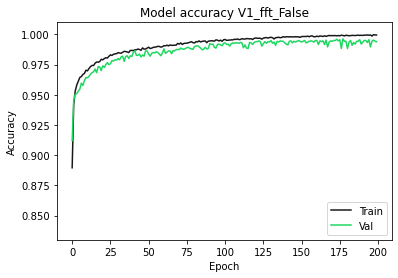

In [24]:
def train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=False):
    
    # model training
    model, model_checkpoint = two_layer_integrated(X_train)
    history = model.fit(X_train, Y_train ,epochs=200, callbacks=[model_checkpoint], batch_size=32, 
                        validation_data=(X_test, Y_test))

    # load the best model weights
    model.load_weights('best_model_whistle.hdf5')
    
    # save model
    model.save("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")

    # summarize history for loss
    if plot:
        plt.plot(history.history["acc"], c="#181818")
        plt.plot(history.history["val_acc"], c="#1ED760")
        plt.title("Model accuracy V" + str(version) + "_" + feature_type + "_" + str(denoise))
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Train", "Val"], loc="lower right")
        plt.ylim([0.83,1.01])
        plt.show()
        
    return model

def train_model(version, feature_type, denoise):
    # load data
    mass_data = build_features(version, feature_type, denoise)
    
    # train test split
    X, Y = feature_target_split(mass_data)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, 
                                                        random_state=12, shuffle=True)
    
    return X_test, Y_test, train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise, plot=True)
        

X_test, Y_test, model = train_model(1, "fft", False)

## Confusion Matrix

acc: 0.9888551235198975


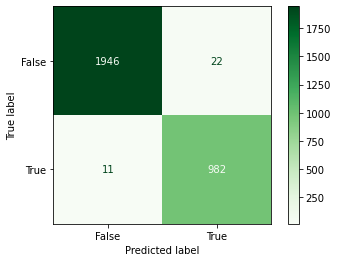

In [12]:
cm = confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
print("acc:", model.evaluate(X_test, Y_test, verbose=0)[1])
disp.plot(cmap="Greens")

## PCA Decomposition

Dataframe succesfully loaded from csv!


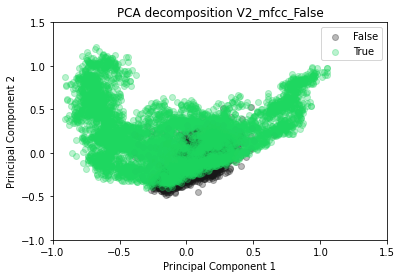

In [13]:
def pca_decompose(version, feature_type, denoise):
    # load data
    df = build_features(version, feature_type, denoise)
    
    # pca decomposition
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df.loc[:, df.columns != "target"])
    pca_df = pd.DataFrame(data = principalComponents, columns = ["dim_1", "dim_2"])
    pca_df.insert (0, "target", df["target"])
    
    # plot
    colors = ["#181818", "#1ED760"]
    for i, label in enumerate(pca_df["target"].unique()):
        pca_label = pca_df[pca_df["target"] == label]
        plt.scatter(pca_label["dim_1"], pca_label["dim_2"], label = bool(label), alpha=0.3, c = colors[i])
    plt.title("PCA decomposition V" + str(version) + "_" + feature_type + "_" + str(denoise))
    plt.xlim([-1,1.5])
    plt.ylim([-1,1.5])
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.show()
    
pca_decompose(2, "mfcc", False)

## K-fold validation

WhistleTest_tuhhnao16.wav 28116000 no fit ;(

Train on 12012 samples, validate on 3003 samples
Epoch 1/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.3141 - acc: 0.8895 - val_loss: 0.1928 - val_acc: 0.9227

Epoch 00001: val_loss improved from inf to 0.19281, saving model to best_model_whistle.hdf5
Epoch 2/200
12012/12012 [==============================] - 0s 28us/step - loss: 0.1672 - acc: 0.9391 - val_loss: 0.1463 - val_acc: 0.9471

Epoch 00002: val_loss improved from 0.19281 to 0.14634, saving model to best_model_whistle.hdf5
Epoch 3/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.1346 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9537

Epoch 00003: val_loss improved from 0.14634 to 0.12890, saving model to best_model_whistle.hdf5
Epoch 4/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.1202 - acc: 0.9568 - val_loss: 0.1098 - val_acc: 0.9587

Epoch 00004: val_loss improved from 0.12890 to 0.10985, saving mo

12012/12012 [==============================] - 0s 29us/step - loss: 0.0413 - acc: 0.9848 - val_loss: 0.0434 - val_acc: 0.9847

Epoch 00037: val_loss improved from 0.04441 to 0.04345, saving model to best_model_whistle.hdf5
Epoch 38/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.0403 - acc: 0.9853 - val_loss: 0.0442 - val_acc: 0.9800

Epoch 00038: val_loss did not improve from 0.04345
Epoch 39/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.0397 - acc: 0.9855 - val_loss: 0.0455 - val_acc: 0.9800

Epoch 00039: val_loss did not improve from 0.04345
Epoch 40/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0385 - acc: 0.9870 - val_loss: 0.0416 - val_acc: 0.9853

Epoch 00040: val_loss improved from 0.04345 to 0.04158, saving model to best_model_whistle.hdf5
Epoch 41/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0389 - acc: 0.9853 - val_loss: 0.0409 - val_acc: 0.9863

Epoch 00041: val_lo

12012/12012 [==============================] - 0s 30us/step - loss: 0.0231 - acc: 0.9912 - val_loss: 0.0322 - val_acc: 0.9903

Epoch 00076: val_loss did not improve from 0.03030
Epoch 77/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0228 - acc: 0.9918 - val_loss: 0.0296 - val_acc: 0.9890

Epoch 00077: val_loss improved from 0.03030 to 0.02959, saving model to best_model_whistle.hdf5
Epoch 78/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0227 - acc: 0.9917 - val_loss: 0.0305 - val_acc: 0.9883

Epoch 00078: val_loss did not improve from 0.02959
Epoch 79/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0222 - acc: 0.9920 - val_loss: 0.0303 - val_acc: 0.9877

Epoch 00079: val_loss did not improve from 0.02959
Epoch 80/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0218 - acc: 0.9918 - val_loss: 0.0310 - val_acc: 0.9903

Epoch 00080: val_loss did not improve from 0.02959
Epoch 81/200



Epoch 00115: val_loss improved from 0.02506 to 0.02458, saving model to best_model_whistle.hdf5
Epoch 116/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.0139 - acc: 0.9957 - val_loss: 0.0246 - val_acc: 0.9910

Epoch 00116: val_loss did not improve from 0.02458
Epoch 117/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0249 - val_acc: 0.9907

Epoch 00117: val_loss did not improve from 0.02458
Epoch 118/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.0138 - acc: 0.9958 - val_loss: 0.0257 - val_acc: 0.9900

Epoch 00118: val_loss did not improve from 0.02458
Epoch 119/200
12012/12012 [==============================] - 0s 28us/step - loss: 0.0135 - acc: 0.9959 - val_loss: 0.0257 - val_acc: 0.9903

Epoch 00119: val_loss did not improve from 0.02458
Epoch 120/200
12012/12012 [==============================] - 0s 27us/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0246 - val_acc: 0.


Epoch 00156: val_loss improved from 0.02255 to 0.02204, saving model to best_model_whistle.hdf5
Epoch 157/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0081 - acc: 0.9984 - val_loss: 0.0233 - val_acc: 0.9923

Epoch 00157: val_loss did not improve from 0.02204
Epoch 158/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0081 - acc: 0.9982 - val_loss: 0.0247 - val_acc: 0.9907

Epoch 00158: val_loss did not improve from 0.02204
Epoch 159/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0081 - acc: 0.9974 - val_loss: 0.0221 - val_acc: 0.9920

Epoch 00159: val_loss did not improve from 0.02204
Epoch 160/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0083 - acc: 0.9981 - val_loss: 0.0259 - val_acc: 0.9900

Epoch 00160: val_loss did not improve from 0.02204
Epoch 161/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0076 - acc: 0.9983 - val_loss: 0.0253 - val_acc: 0.

12012/12012 [==============================] - 0s 29us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0216 - val_acc: 0.9917

Epoch 00198: val_loss did not improve from 0.02158
Epoch 199/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0050 - acc: 0.9994 - val_loss: 0.0215 - val_acc: 0.9920

Epoch 00199: val_loss improved from 0.02158 to 0.02149, saving model to best_model_whistle.hdf5
Epoch 200/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0230 - val_acc: 0.9913

Epoch 00200: val_loss did not improve from 0.02149
Train on 12012 samples, validate on 3003 samples
Epoch 1/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.3099 - acc: 0.8885 - val_loss: 0.2075 - val_acc: 0.9174

Epoch 00001: val_loss improved from inf to 0.20750, saving model to best_model_whistle.hdf5
Epoch 2/200
12012/12012 [==============================] - 0s 28us/step - loss: 0.1631 - acc: 0.9404 - val_loss: 


Epoch 00034: val_loss did not improve from 0.04935
Epoch 35/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0382 - acc: 0.9860 - val_loss: 0.0487 - val_acc: 0.9817

Epoch 00035: val_loss improved from 0.04935 to 0.04867, saving model to best_model_whistle.hdf5
Epoch 36/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0364 - acc: 0.9870 - val_loss: 0.0479 - val_acc: 0.9807

Epoch 00036: val_loss improved from 0.04867 to 0.04792, saving model to best_model_whistle.hdf5
Epoch 37/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0357 - acc: 0.9873 - val_loss: 0.0466 - val_acc: 0.9837

Epoch 00037: val_loss improved from 0.04792 to 0.04658, saving model to best_model_whistle.hdf5
Epoch 38/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0348 - acc: 0.9871 - val_loss: 0.0465 - val_acc: 0.9830

Epoch 00038: val_loss improved from 0.04658 to 0.04652, saving model to best_model_whistle.hdf5
Epoc


Epoch 00073: val_loss did not improve from 0.03212
Epoch 74/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0186 - acc: 0.9938 - val_loss: 0.0336 - val_acc: 0.9870

Epoch 00074: val_loss did not improve from 0.03212
Epoch 75/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0190 - acc: 0.9938 - val_loss: 0.0322 - val_acc: 0.9853

Epoch 00075: val_loss did not improve from 0.03212
Epoch 76/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0182 - acc: 0.9937 - val_loss: 0.0340 - val_acc: 0.9887

Epoch 00076: val_loss did not improve from 0.03212
Epoch 77/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0331 - val_acc: 0.9880

Epoch 00077: val_loss did not improve from 0.03212
Epoch 78/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0187 - acc: 0.9942 - val_loss: 0.0324 - val_acc: 0.9893

Epoch 00078: val_loss did not improve from 0

12012/12012 [==============================] - 0s 33us/step - loss: 0.0109 - acc: 0.9970 - val_loss: 0.0247 - val_acc: 0.9910

Epoch 00114: val_loss did not improve from 0.02463
Epoch 115/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0109 - acc: 0.9972 - val_loss: 0.0242 - val_acc: 0.9913

Epoch 00115: val_loss improved from 0.02463 to 0.02421, saving model to best_model_whistle.hdf5
Epoch 116/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0121 - acc: 0.9966 - val_loss: 0.0254 - val_acc: 0.9913

Epoch 00116: val_loss did not improve from 0.02421
Epoch 117/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0105 - acc: 0.9973 - val_loss: 0.0247 - val_acc: 0.9893

Epoch 00117: val_loss did not improve from 0.02421
Epoch 118/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0261 - val_acc: 0.9907

Epoch 00118: val_loss did not improve from 0.02421
Epoch 119

12012/12012 [==============================] - 0s 36us/step - loss: 0.0075 - acc: 0.9981 - val_loss: 0.0214 - val_acc: 0.9923

Epoch 00154: val_loss did not improve from 0.01890
Epoch 155/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0068 - acc: 0.9985 - val_loss: 0.0196 - val_acc: 0.9933

Epoch 00155: val_loss did not improve from 0.01890
Epoch 156/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0071 - acc: 0.9983 - val_loss: 0.0196 - val_acc: 0.9937

Epoch 00156: val_loss did not improve from 0.01890
Epoch 157/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.0215 - val_acc: 0.9917

Epoch 00157: val_loss did not improve from 0.01890
Epoch 158/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0069 - acc: 0.9985 - val_loss: 0.0201 - val_acc: 0.9933

Epoch 00158: val_loss did not improve from 0.01890
Epoch 159/200
12012/12012 [===========================

12012/12012 [==============================] - 0s 34us/step - loss: 0.0041 - acc: 0.9992 - val_loss: 0.0159 - val_acc: 0.9940

Epoch 00195: val_loss did not improve from 0.01568
Epoch 196/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0225 - val_acc: 0.9913

Epoch 00196: val_loss did not improve from 0.01568
Epoch 197/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0175 - val_acc: 0.9927

Epoch 00197: val_loss did not improve from 0.01568
Epoch 198/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0176 - val_acc: 0.9930

Epoch 00198: val_loss did not improve from 0.01568
Epoch 199/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0043 - acc: 0.9995 - val_loss: 0.0168 - val_acc: 0.9937

Epoch 00199: val_loss did not improve from 0.01568
Epoch 200/200
12012/12012 [===========================

12012/12012 [==============================] - 0s 38us/step - loss: 0.0435 - acc: 0.9842 - val_loss: 0.0463 - val_acc: 0.9824

Epoch 00031: val_loss improved from 0.04748 to 0.04632, saving model to best_model_whistle.hdf5
Epoch 32/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0431 - acc: 0.9838 - val_loss: 0.0449 - val_acc: 0.9833

Epoch 00032: val_loss improved from 0.04632 to 0.04487, saving model to best_model_whistle.hdf5
Epoch 33/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0406 - acc: 0.9853 - val_loss: 0.0443 - val_acc: 0.9840

Epoch 00033: val_loss improved from 0.04487 to 0.04430, saving model to best_model_whistle.hdf5
Epoch 34/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0402 - acc: 0.9855 - val_loss: 0.0438 - val_acc: 0.9847

Epoch 00034: val_loss improved from 0.04430 to 0.04381, saving model to best_model_whistle.hdf5
Epoch 35/200
12012/12012 [==============================] - 0s 31us/s


Epoch 00068: val_loss did not improve from 0.02755
Epoch 69/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0197 - acc: 0.9934 - val_loss: 0.0291 - val_acc: 0.9903

Epoch 00069: val_loss did not improve from 0.02755
Epoch 70/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0194 - acc: 0.9936 - val_loss: 0.0274 - val_acc: 0.9883

Epoch 00070: val_loss improved from 0.02755 to 0.02743, saving model to best_model_whistle.hdf5
Epoch 71/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0299 - val_acc: 0.9873

Epoch 00071: val_loss did not improve from 0.02743
Epoch 72/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0191 - acc: 0.9933 - val_loss: 0.0283 - val_acc: 0.9903

Epoch 00072: val_loss did not improve from 0.02743
Epoch 73/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0176 - acc: 0.9941 - val_loss: 0.0265 - val_acc: 0.9883


12012/12012 [==============================] - 0s 32us/step - loss: 0.0105 - acc: 0.9973 - val_loss: 0.0199 - val_acc: 0.9920

Epoch 00108: val_loss did not improve from 0.01866
Epoch 109/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0104 - acc: 0.9971 - val_loss: 0.0185 - val_acc: 0.9933

Epoch 00109: val_loss improved from 0.01866 to 0.01851, saving model to best_model_whistle.hdf5
Epoch 110/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0105 - acc: 0.9975 - val_loss: 0.0189 - val_acc: 0.9923

Epoch 00110: val_loss did not improve from 0.01851
Epoch 111/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0098 - acc: 0.9975 - val_loss: 0.0181 - val_acc: 0.9920

Epoch 00111: val_loss improved from 0.01851 to 0.01813, saving model to best_model_whistle.hdf5
Epoch 112/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0098 - acc: 0.9974 - val_loss: 0.0186 - val_acc: 0.9917

Epoch 00112: va

12012/12012 [==============================] - 0s 36us/step - loss: 0.0052 - acc: 0.9992 - val_loss: 0.0286 - val_acc: 0.9913

Epoch 00149: val_loss did not improve from 0.01484
Epoch 150/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.0249 - val_acc: 0.9930

Epoch 00150: val_loss did not improve from 0.01484
Epoch 151/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0067 - acc: 0.9983 - val_loss: 0.0246 - val_acc: 0.9940

Epoch 00151: val_loss did not improve from 0.01484
Epoch 152/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0338 - val_acc: 0.9923

Epoch 00152: val_loss did not improve from 0.01484
Epoch 153/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0051 - acc: 0.9992 - val_loss: 0.0332 - val_acc: 0.9933

Epoch 00153: val_loss did not improve from 0.01484
Epoch 154/200
12012/12012 [===========================

12012/12012 [==============================] - 0s 31us/step - loss: 0.0029 - acc: 0.9995 - val_loss: 0.0226 - val_acc: 0.9957

Epoch 00190: val_loss did not improve from 0.01138
Epoch 191/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0029 - acc: 0.9998 - val_loss: 0.0251 - val_acc: 0.9927

Epoch 00191: val_loss did not improve from 0.01138
Epoch 192/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0028 - acc: 0.9998 - val_loss: 0.0185 - val_acc: 0.9963

Epoch 00192: val_loss did not improve from 0.01138
Epoch 193/200
12012/12012 [==============================] - 0s 39us/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0240 - val_acc: 0.9940

Epoch 00193: val_loss did not improve from 0.01138
Epoch 194/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0244 - val_acc: 0.9943

Epoch 00194: val_loss did not improve from 0.01138
Epoch 195/200
12012/12012 [===========================

Epoch 28/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0477 - acc: 0.9820 - val_loss: 0.0594 - val_acc: 0.9797

Epoch 00028: val_loss did not improve from 0.05282
Epoch 29/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0466 - acc: 0.9826 - val_loss: 0.0500 - val_acc: 0.9817

Epoch 00029: val_loss improved from 0.05282 to 0.05005, saving model to best_model_whistle.hdf5
Epoch 30/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0456 - acc: 0.9833 - val_loss: 0.0488 - val_acc: 0.9810

Epoch 00030: val_loss improved from 0.05005 to 0.04878, saving model to best_model_whistle.hdf5
Epoch 31/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0446 - acc: 0.9832 - val_loss: 0.0466 - val_acc: 0.9817

Epoch 00031: val_loss improved from 0.04878 to 0.04661, saving model to best_model_whistle.hdf5
Epoch 32/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0426 - acc: 0.9846

12012/12012 [==============================] - 0s 29us/step - loss: 0.0257 - acc: 0.9897 - val_loss: 0.0362 - val_acc: 0.9880

Epoch 00066: val_loss did not improve from 0.02977
Epoch 67/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0243 - acc: 0.9905 - val_loss: 0.0290 - val_acc: 0.9887

Epoch 00067: val_loss improved from 0.02977 to 0.02905, saving model to best_model_whistle.hdf5
Epoch 68/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0228 - acc: 0.9906 - val_loss: 0.0310 - val_acc: 0.9883

Epoch 00068: val_loss did not improve from 0.02905
Epoch 69/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0234 - acc: 0.9906 - val_loss: 0.0298 - val_acc: 0.9883

Epoch 00069: val_loss did not improve from 0.02905
Epoch 70/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0230 - acc: 0.9918 - val_loss: 0.0291 - val_acc: 0.9890

Epoch 00070: val_loss did not improve from 0.02905
Epoch 71/200



Epoch 00105: val_loss did not improve from 0.02179
Epoch 106/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0140 - acc: 0.9955 - val_loss: 0.0213 - val_acc: 0.9917

Epoch 00106: val_loss improved from 0.02179 to 0.02134, saving model to best_model_whistle.hdf5
Epoch 107/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0158 - acc: 0.9948 - val_loss: 0.0214 - val_acc: 0.9913

Epoch 00107: val_loss did not improve from 0.02134
Epoch 108/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0138 - acc: 0.9955 - val_loss: 0.0236 - val_acc: 0.9897

Epoch 00108: val_loss did not improve from 0.02134
Epoch 109/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0145 - acc: 0.9953 - val_loss: 0.0222 - val_acc: 0.9930

Epoch 00109: val_loss did not improve from 0.02134
Epoch 110/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0136 - acc: 0.9950 - val_loss: 0.0208 - val_acc: 0.


Epoch 00146: val_loss did not improve from 0.01676
Epoch 147/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.0189 - val_acc: 0.9937

Epoch 00147: val_loss did not improve from 0.01676
Epoch 148/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0087 - acc: 0.9980 - val_loss: 0.0223 - val_acc: 0.9927

Epoch 00148: val_loss did not improve from 0.01676
Epoch 149/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0301 - val_acc: 0.9927

Epoch 00149: val_loss did not improve from 0.01676
Epoch 150/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0189 - val_acc: 0.9930

Epoch 00150: val_loss did not improve from 0.01676
Epoch 151/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0085 - acc: 0.9977 - val_loss: 0.0179 - val_acc: 0.9943

Epoch 00151: val_loss did not improve f

12012/12012 [==============================] - 0s 30us/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0205 - val_acc: 0.9927

Epoch 00188: val_loss did not improve from 0.01459
Epoch 189/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0057 - acc: 0.9991 - val_loss: 0.0176 - val_acc: 0.9923

Epoch 00189: val_loss did not improve from 0.01459
Epoch 190/200
12012/12012 [==============================] - 0s 30us/step - loss: 0.0055 - acc: 0.9990 - val_loss: 0.0164 - val_acc: 0.9943

Epoch 00190: val_loss did not improve from 0.01459
Epoch 191/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0159 - val_acc: 0.9933

Epoch 00191: val_loss did not improve from 0.01459
Epoch 192/200
12012/12012 [==============================] - 0s 37us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0161 - val_acc: 0.9950

Epoch 00192: val_loss did not improve from 0.01459
Epoch 193/200
12012/12012 [===========================

12012/12012 [==============================] - 0s 35us/step - loss: 0.0523 - acc: 0.9803 - val_loss: 0.0534 - val_acc: 0.9784

Epoch 00026: val_loss improved from 0.05453 to 0.05344, saving model to best_model_whistle.hdf5
Epoch 27/200
12012/12012 [==============================] - 0s 42us/step - loss: 0.0502 - acc: 0.9814 - val_loss: 0.0542 - val_acc: 0.9777

Epoch 00027: val_loss did not improve from 0.05344
Epoch 28/200
12012/12012 [==============================] - 0s 35us/step - loss: 0.0497 - acc: 0.9814 - val_loss: 0.0496 - val_acc: 0.9833

Epoch 00028: val_loss improved from 0.05344 to 0.04959, saving model to best_model_whistle.hdf5
Epoch 29/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0487 - acc: 0.9814 - val_loss: 0.0484 - val_acc: 0.9820

Epoch 00029: val_loss improved from 0.04959 to 0.04838, saving model to best_model_whistle.hdf5
Epoch 30/200
12012/12012 [==============================] - 0s 33us/step - loss: 0.0480 - acc: 0.9819 - val_loss: 


Epoch 00064: val_loss improved from 0.03339 to 0.03310, saving model to best_model_whistle.hdf5
Epoch 65/200
12012/12012 [==============================] - 0s 36us/step - loss: 0.0328 - acc: 0.9887 - val_loss: 0.0320 - val_acc: 0.9880

Epoch 00065: val_loss improved from 0.03310 to 0.03197, saving model to best_model_whistle.hdf5
Epoch 66/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0281 - acc: 0.9897 - val_loss: 0.0323 - val_acc: 0.9890

Epoch 00066: val_loss did not improve from 0.03197
Epoch 67/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0284 - acc: 0.9893 - val_loss: 0.0313 - val_acc: 0.9893

Epoch 00067: val_loss improved from 0.03197 to 0.03128, saving model to best_model_whistle.hdf5
Epoch 68/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0281 - acc: 0.9899 - val_loss: 0.0403 - val_acc: 0.9863

Epoch 00068: val_loss did not improve from 0.03128
Epoch 69/200
12012/12012 [=======================

12012/12012 [==============================] - 0s 29us/step - loss: 0.0195 - acc: 0.9933 - val_loss: 0.0389 - val_acc: 0.9863

Epoch 00105: val_loss did not improve from 0.02595
Epoch 106/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0200 - acc: 0.9928 - val_loss: 0.0275 - val_acc: 0.9897

Epoch 00106: val_loss did not improve from 0.02595
Epoch 107/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0193 - acc: 0.9933 - val_loss: 0.0261 - val_acc: 0.9913

Epoch 00107: val_loss did not improve from 0.02595
Epoch 108/200
12012/12012 [==============================] - 0s 31us/step - loss: 0.0191 - acc: 0.9933 - val_loss: 0.0290 - val_acc: 0.9877

Epoch 00108: val_loss did not improve from 0.02595
Epoch 109/200
12012/12012 [==============================] - 0s 34us/step - loss: 0.0192 - acc: 0.9938 - val_loss: 0.0291 - val_acc: 0.9893

Epoch 00109: val_loss did not improve from 0.02595
Epoch 110/200
12012/12012 [===========================

12012/12012 [==============================] - 0s 32us/step - loss: 0.0140 - acc: 0.9949 - val_loss: 0.0235 - val_acc: 0.9927

Epoch 00146: val_loss did not improve from 0.02237
Epoch 147/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0148 - acc: 0.9945 - val_loss: 0.0223 - val_acc: 0.9920

Epoch 00147: val_loss improved from 0.02237 to 0.02226, saving model to best_model_whistle.hdf5
Epoch 148/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0133 - acc: 0.9957 - val_loss: 0.0227 - val_acc: 0.9920

Epoch 00148: val_loss did not improve from 0.02226
Epoch 149/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0142 - acc: 0.9952 - val_loss: 0.0238 - val_acc: 0.9917

Epoch 00149: val_loss did not improve from 0.02226
Epoch 150/200
12012/12012 [==============================] - 0s 28us/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0225 - val_acc: 0.9917

Epoch 00150: val_loss did not improve from 0.02226
Epoch 151

12012/12012 [==============================] - 0s 33us/step - loss: 0.0106 - acc: 0.9968 - val_loss: 0.0226 - val_acc: 0.9917

Epoch 00187: val_loss did not improve from 0.02072
Epoch 188/200
12012/12012 [==============================] - 0s 32us/step - loss: 0.0100 - acc: 0.9965 - val_loss: 0.0237 - val_acc: 0.9920

Epoch 00188: val_loss did not improve from 0.02072
Epoch 189/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0208 - val_acc: 0.9930

Epoch 00189: val_loss did not improve from 0.02072
Epoch 190/200
12012/12012 [==============================] - 0s 28us/step - loss: 0.0098 - acc: 0.9971 - val_loss: 0.0212 - val_acc: 0.9917

Epoch 00190: val_loss did not improve from 0.02072
Epoch 191/200
12012/12012 [==============================] - 0s 29us/step - loss: 0.0102 - acc: 0.9969 - val_loss: 0.0212 - val_acc: 0.9927

Epoch 00191: val_loss did not improve from 0.02072
Epoch 192/200
12012/12012 [===========================

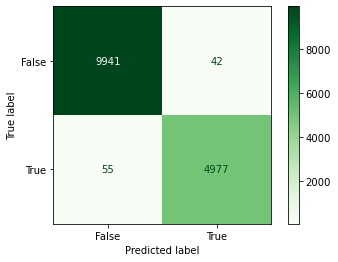

In [14]:
# Kfold implementation, written by Paul Boersma
def kfold_index(df, k=5):
    N = len(df)
    minimum_number_of_points_per_slice = N // k
    remaining_number_of_points = N % k
    starting_point = 0
    out = []
    for islice in range(0, k):
        end_point = starting_point + minimum_number_of_points_per_slice + ( islice < remaining_number_of_points )
        out.append((starting_point, end_point))
        starting_point = end_point
    return out

# Run kfold for given featureset
def execute_kfold(version, feature_type, denoise, k=5):
    acc_train = []
    acc_test = []
    cm = np.zeros((2,2), dtype=int)
    df = build_features(version, feature_type, denoise)
    X, Y = feature_target_split(df)
    for start, end in kfold_index(df, k):
        X_train = np.concatenate((X[:start], X[end:]))
        Y_train = np.concatenate((Y[:start], Y[end:]))
        X_test = X[start:end]
        Y_test = Y[start:end]
        
        model = train(X_train, X_test, Y_train, Y_test, version, feature_type, denoise)
        acc_train.append(model.evaluate(X_train, Y_train, verbose=0)[1])
        acc_test.append(model.evaluate(X_test, Y_test, verbose=0)[1])
        cm += confusion_matrix(Y_test, [1 if prediction > .5 else 0 for prediction in model.predict(X_test)[:,0]])
        
    print("Accuracy on train data:", acc_train, np.mean(acc_train))
    print("Accuracy on test data:", acc_test, np.mean(acc_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
    disp.plot(cmap="Greens", values_format="")

#execute_kfold(1, "fft", False)

# Live detection

In [53]:
# constants
FORMAT = pyaudio.paFloat32      # audio format (bytes per sample?)
CHANNELS = 1                    # single channel for microphone
SR = 48000                      # samples per second
CHUNK = int((SR / 1000) * STEP) # chunk size

In [62]:
def get_noise_sample():
    WAVE_OUTPUT_FILENAME = "noise_sample.wav"
    RECORD_SECONDS = 1
    p = pyaudio.PyAudio()
    stream = p.open(
        format=pyaudio.paInt16,
        channels=CHANNELS,
        rate=SR,
        input=True,
        output=True,
        frames_per_buffer=CHUNK
    )

    print("* recording denoise", int(SR / CHUNK * RECORD_SECONDS))

    frames = []

    for i in range(0, int(SR / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("* done recording denoise")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
    wf.setframerate(SR)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    # load file & meta data
    sample, sample_rate = librosa.load(WAVE_OUTPUT_FILENAME, sr=None)
    return nr.reduce_noise(y=sample,  y_noise=sample[:5000], sr=SR)

In [64]:
def live_detect(feature_type, version, denoise, record_seconds=10):
    # load model
    try:
        model = load_model("model_v" + str(version) + "_" + feature_type + "_" + str(denoise) + ".h5")
    except:
        _, _, model = train_model(version, feature_type, denoise)
    
    # pyaudio class instance
    p = pyaudio.PyAudio()
    buffer = [False] * 10
    
    if denoise:
        noise_sample = get_noise_sample()

    # stream object to get data from microphone
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=SR,
        input=True,
        output=True,
        frames_per_buffer=CHUNK
    )

    print("recording...", int(SR / CHUNK * record_seconds))
    frames = []

    for i in range(0, int(SR / CHUNK * record_seconds)):
        # read chunk
        data = stream.read(CHUNK)
        frames.append(data)
        
        # fetch features
        sample = np.frombuffer(data, dtype=np.float32)
        
        if denoise == True:
            sample = nr.reduce_noise(y=sample,  y_noise=noise_sample, sr=SR)
            
        # get features
        if feature_type == "fft":
            features = np.mean(np.abs(librosa.stft(sample, n_fft=512, hop_length=256, win_length=512)).T, axis=0)
        elif feature_type == "mfcc":
            features = np.mean(librosa.feature.mfcc(y=sample, sr=SR, n_mfcc=40).T, axis=0)
        
        # make prediction
        features = np.expand_dims(features, axis=0)
        is_whistle = model.predict(features, verbose=0)[0][0]
        
        # print current certainty
        buffer.pop(0)
        buffer.append(is_whistle > .5)
        clear_output(wait=True)
        print("whistle likelihood:", str((sum(buffer)/len(buffer)) * 100) + "%", i)
        
        
    print("finished recording")

    # stop recording
    stream.stop_stream()
    stream.close()
    p.terminate()
        
live_detect("mfcc", 1, True)

whistle likelihood: 0.0% 199
finished recording
